In [1]:
%%capture

import pandas as pd
import numpy as np
import tensorflow as tf
import mlts

import altair as alt
alt.renderers.enable('notebook')

## Load data

In [2]:
data = mlts.io.merge([
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv'),
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv'),
])

In [3]:
mlts.io.check(data)

In [4]:
K = len(data.iloc[:, 0].value_counts())
dss, mu, sigma = mlts.io.normalize(mlts.io.split(data, ycol=0, shape=(42048), seed=1))
ds_train, ds_dev, ds_test = mlts.tf.to_dataset(mlts.io.reshape(dss, target_shape=(28, 28, 1)), batch_size=32)

## Implement the model

In [5]:
class FasionMNISTAdapter(mlts.tf.adapter.Model):
    def __init__(self, *args, **kwargs):
        super(FasionMNISTAdapter, self).__init__(*args, **kwargs)

    @staticmethod
    def model(options, hparams = {}):        
        regularization = None
        if "lambda" in hparams:
            regularization = tf.keras.regularizers.l2(l=hparams["lambda"])

        return tf.keras.models.Sequential([
            ## The reason of using 'InputLayer' is only to
            ## show up a shape of each layer in `model.summary()`.
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                512,
                activation=tf.nn.relu,
                kernel_initializer=tf.keras.initializers.he_uniform(options.seed),
                kernel_regularizer=regularization,
            ),
            tf.keras.layers.Dense(
                K,
                activation=tf.nn.softmax,
                kernel_initializer=tf.keras.initializers.he_uniform(options.seed),
                kernel_regularizer=regularization,
            ),
        ])
    
    @staticmethod
    def loss(options):
        return tf.keras.losses.SparseCategoricalCrossentropy()
    
    @staticmethod
    def optimization(options, hparams, m, ds, metrics=[], callbacks=[]):
        m.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=hparams.get("alpha", 0.001),
                beta_1=hparams.get("beta_1", 0.9),
                beta_2=hparams.get("beta_2", 0.999),
            ),
            loss=FasionMNISTAdapter.loss(options),
            metrics=metrics,
        )

        if options.seed != None: tf.random.set_seed(options.seed)
        m.fit(
            ds,
            epochs=options.epochs,
            shuffle=False,
            callbacks=callbacks,
            verbose=options.verbose,
        )
        
        return m

## Tune hyperparameters

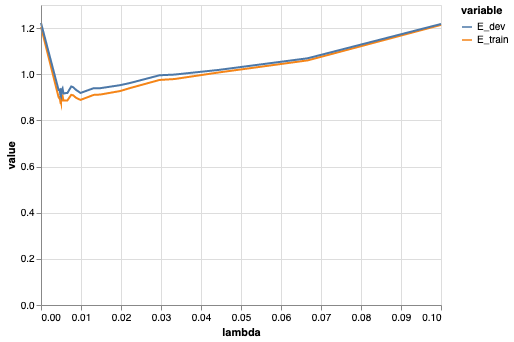

In [8]:
ad = FasionMNISTAdapter(mlts.tf.adapter.Options(epochs=100, seed=1))
_, lambda_hist = ad.tune_hyperparameters(
    mlts.tf.generator.LambdaRange(start=0.0001, stop=0.1),
    ds_train.take(100),
    ds_dev,
)
alt.Chart(lambda_hist.melt(id_vars="lambda")).mark_line().encode(
    x = "lambda",
    y = "value",
    color = "variable"
)

In [9]:
pd.DataFrame(ad.hparams, index=["hparam"])[["lambda"]].transpose()

,hparam
lambda,0.005014


In [10]:
lambda_hist

,E_train,E_dev,lambda
0,1.204638,1.222326,0.000001
1,0.979106,0.998462,0.033334
2,1.060065,1.069146,0.066667
3,1.213797,1.217713,0.100000
4,0.939867,0.961861,0.022223
5,1.007741,1.018743,0.044445
6,0.911974,0.939541,0.014816
7,0.975223,0.995470,0.029630
8,0.888774,0.918927,0.009877
9,0.927027,0.952544,0.019754
